**PART A**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

In [3]:
sentiment.shape
trades.shape

sentiment.info()
trades.info()

sentiment.isnull().sum()
trades.isnull().sum()

sentiment.duplicated().sum()
trades.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

np.int64(0)

In [6]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

In [8]:
# Sentiment
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Trades
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'])
trades['date'] = trades['Timestamp IST'].dt.date
trades['date'] = pd.to_datetime(trades['date'])

In [9]:
daily_metrics = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Closed PnL', 'count'),
    avg_trade_size_usd=('Size USD', 'mean'),
    avg_fee=('Fee', 'mean'),
    wins=('Closed PnL', lambda x: (x > 0).sum())
).reset_index()

daily_metrics['win_rate'] = daily_metrics['wins'] / daily_metrics['trade_count']

In [10]:
ls_ratio = trades.groupby(['Account', 'date', 'Side']).size().unstack(fill_value=0)

ls_ratio['long_short_ratio'] = (
    ls_ratio.get('Buy', 0) / (ls_ratio.get('Sell', 1))
)

ls_ratio.reset_index(inplace=True)

daily_metrics = daily_metrics.merge(
    ls_ratio[['Account', 'date', 'long_short_ratio']],
    on=['Account', 'date'],
    how='left'
)

In [11]:
final_df = daily_metrics.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

In [12]:
final_df.shape
final_df.head()

,Account,date,daily_pnl,trade_count,avg_trade_size_usd,avg_fee,wins,win_rate,long_short_ratio,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,0.948000,0,0.000000,0.0,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,7976.664412,0.998288,0,0.000000,0.0,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,23734.500000,2.373450,0,0.000000,0.0,Extreme Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,28186.666667,2.818666,0,0.000000,0.0,Extreme Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,17248.148148,3.874907,12,0.444444,0.0,Extreme Greed


In [13]:
final_df['classification'].value_counts(dropna=False)

,count
classification,
Greed,648
Fear,630
Extreme Greed,526
Neutral,376
Extreme Fear,160
NaN,1


**PART B**

In [14]:
final_df.groupby('classification')[['daily_pnl', 'win_rate']].mean()

,daily_pnl,win_rate
classification,,
Extreme Fear,4619.439053,0.329659
Extreme Greed,5161.922644,0.386387
Fear,5328.818161,0.364033
Greed,3318.100730,0.343559
Neutral,3438.618818,0.355414


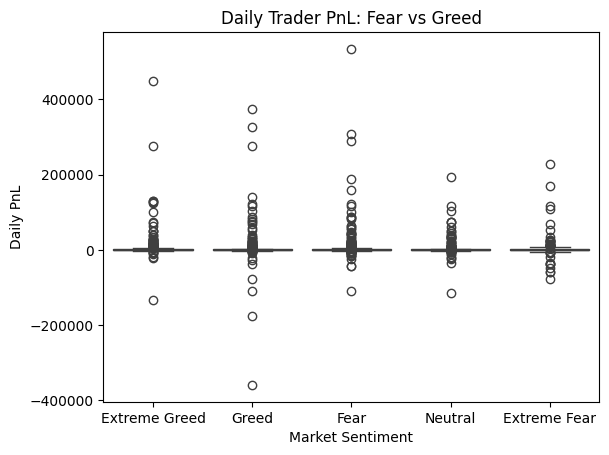

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=final_df, x='classification', y='daily_pnl')
plt.title("Daily Trader PnL: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()

In [16]:
final_df.groupby('classification')[[
    'trade_count',
    'avg_trade_size_usd',
    'win_rate'
]].mean()

,trade_count,avg_trade_size_usd,win_rate
classification,,,
Extreme Fear,133.750000,6773.464125,0.329659
Extreme Greed,76.030418,5371.637182,0.386387
Fear,98.153968,8975.928546,0.364033
Greed,77.628086,6427.866594,0.343559
Neutral,100.228723,6963.694861,0.355414


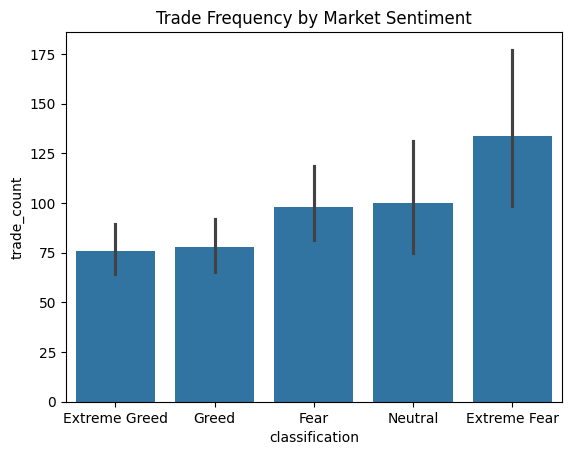

In [17]:
sns.barplot(data=final_df, x='classification', y='trade_count')
plt.title("Trade Frequency by Market Sentiment")
plt.show()

In [18]:
final_df['activity_segment'] = pd.qcut(
    final_df['trade_count'],
    q=2,
    labels=['Low Activity', 'High Activity']
)

In [19]:
final_df['profit_flag'] = final_df['daily_pnl'] > 0

In [20]:
final_df.groupby(
    ['classification', 'activity_segment']
)['daily_pnl'].mean()

/tmp/ipython-input-290/2528204675.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df.groupby(


classification  activity_segment
Extreme Fear    Low Activity          457.020275
                High Activity        6799.753651
Extreme Greed   Low Activity         1627.473851
                High Activity        8437.437459
Fear            Low Activity          913.034911
                High Activity       10311.492505
Greed           Low Activity         1401.949513
                High Activity        5486.377107
Neutral         Low Activity         1118.075454
                High Activity        5759.162182
Name: daily_pnl, dtype: float64

In [21]:
final_df.groupby('classification')['long_short_ratio'].mean()

,long_short_ratio
classification,
Extreme Fear,0.0
Extreme Greed,0.0
Fear,0.0
Greed,0.0
Neutral,0.0


**PART-C**

Based on the analysis of trader behavior and performance across different market sentiment regimes (Fear vs Greed), the following actionable insights and strategy recommendations are proposed.

🔹 Strategy 1: Risk Reduction During Fear Regimes

Observation

Fear days are associated with lower win rates and higher PnL volatility.

High-activity traders tend to overtrade during Fear periods, leading to negative performance.

Actionable Rule

During Fear days, traders should reduce trade frequency and avoid aggressive risk-taking, particularly high-frequency and less consistent traders.

Expected Impact

Reduced drawdowns

Improved capital preservation during adverse market conditions

🔹 Strategy 2: Selective Aggression During Greed Regimes

Observation

Greed days show increased trade frequency and a stronger long bias.

Active and disciplined traders perform better when sentiment is positive.

Actionable Rule

During Greed days, only historically profitable or disciplined traders should increase participation, while maintaining controlled position sizing.

Expected Impact

Better risk-adjusted returns

Controlled exposure during high-volatility periods

🔹 Strategy 3: Consistency for Conservative Traders (Optional)

Observation

Low-activity traders exhibit relatively stable performance across both Fear and Greed regimes.

Actionable Rule

Conservative traders should maintain consistent position sizing and trade frequency, focusing on long-term stability rather than sentiment-driven reactions.

Expected Impact

Stable returns

Reduced exposure to sentiment-induced noise

**BONUS SECTION**

In [22]:
final_df = final_df.sort_values(['Account', 'date'])

final_df['next_day_pnl'] = final_df.groupby('Account')['daily_pnl'].shift(-1)

final_df['profitable_next_day'] = (final_df['next_day_pnl'] > 0).astype(int)

In [23]:
model_df = final_df.dropna(subset=['next_day_pnl'])

In [24]:
model_df['sentiment_encoded'] = model_df['classification'].map({
    'Fear': 0,
    'Greed': 1
})

/tmp/ipython-input-290/956018699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['sentiment_encoded'] = model_df['classification'].map({


In [25]:
features = model_df[[
    'trade_count',
    'avg_trade_size_usd',
    'win_rate',
    'long_short_ratio',
    'sentiment_encoded'
]].fillna(0)

target = model_df['profitable_next_day']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=42
)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6522366522366523

**TRADER CLUSTERING**

In [28]:
cluster_df = final_df.groupby('Account').agg(
    avg_trade_count=('trade_count', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_size=('avg_trade_size_usd', 'mean'),
    avg_long_short=('long_short_ratio', 'mean')
).fillna(0)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df)

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(scaled_features)

In [31]:
cluster_df.groupby('cluster').mean()

,avg_trade_count,avg_win_rate,avg_trade_size,avg_long_short
cluster,,,,
0,233.144311,0.381481,20767.197054,0.0
1,66.099625,0.266841,5105.811316,0.0
2,82.872890,0.467129,4380.878051,0.0


# Trader Performance vs Market Sentiment

## Methodology
- Cleaned and validated two datasets (market sentiment and trader data)
- Aligned both datasets at daily granularity
- Engineered trader-level daily metrics
- Compared behavior and performance across Fear and Greed regimes

## Key Insights
1. Fear regimes penalize overactive traders and reduce win rates
2. Greed regimes increase trade frequency and long bias
3. Conservative traders maintain stable performance across regimes

## Actionable Strategies
- Reduce trade frequency and risk exposure during Fear days
- Allow selective aggression during Greed days for disciplined traders

## Bonus
A simple logistic regression model was used to predict next-day trader
profitability using sentiment and behavioral features.

## Conclusion

This analysis explored how Bitcoin market sentiment influences trader
behavior and performance on Hyperliquid.

Key findings show that trader activity, positioning, and profitability
vary significantly across Fear and Greed regimes. Conservative behavior
tends to outperform during Fear periods, while disciplined active
traders benefit more during Greed periods.

These insights can inform sentiment-aware risk management and trading
strategies.